In [21]:
from subprocess import check_output
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Первинний аналіз даних
www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [22]:
data = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', parse_dates=["date"])
# test = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv', parse_dates=["date"])

data = data.set_index("date").sort_index()

In [23]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


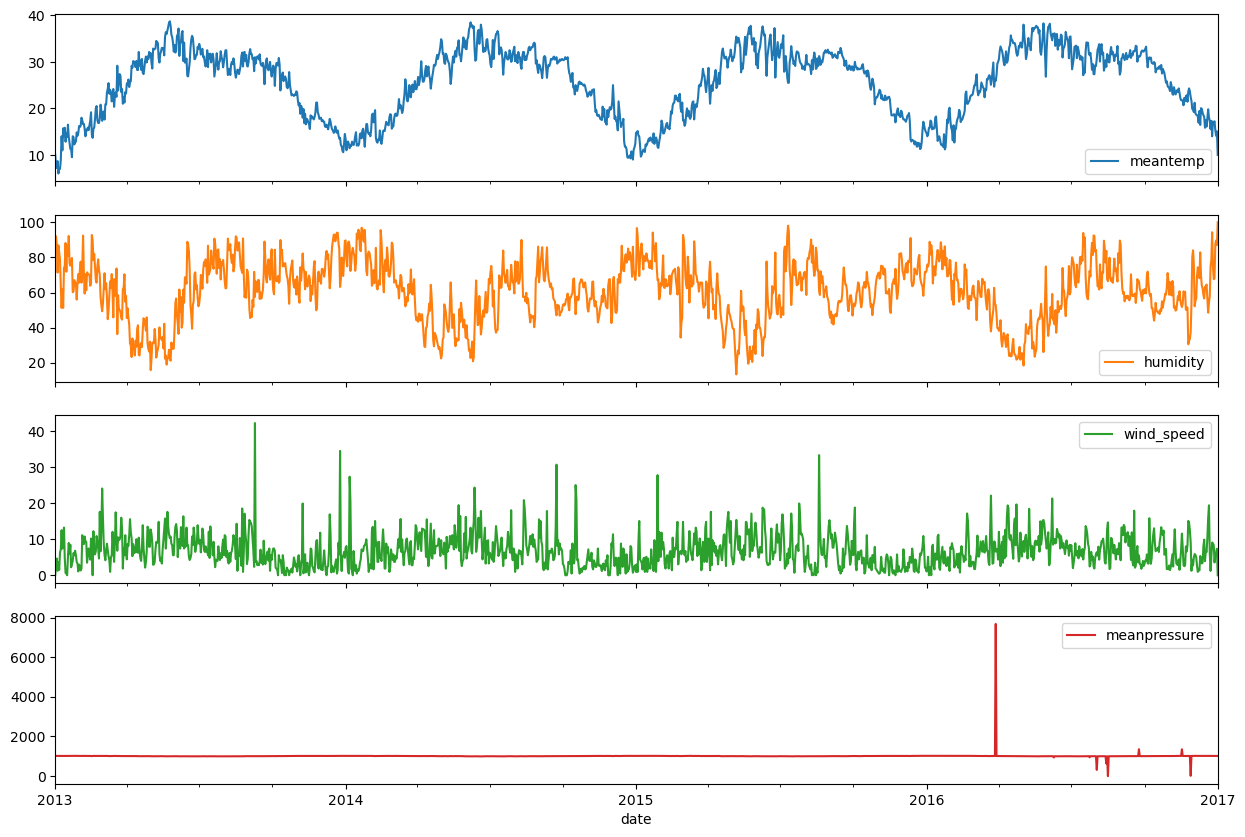

In [24]:
data.plot(subplots=True, figsize=(15, 10));

In [25]:
print(data.isna().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [26]:
np.all(data.resample('D').asfreq().index == data.index)

True

## Підготовка даних

<Axes: xlabel='date'>

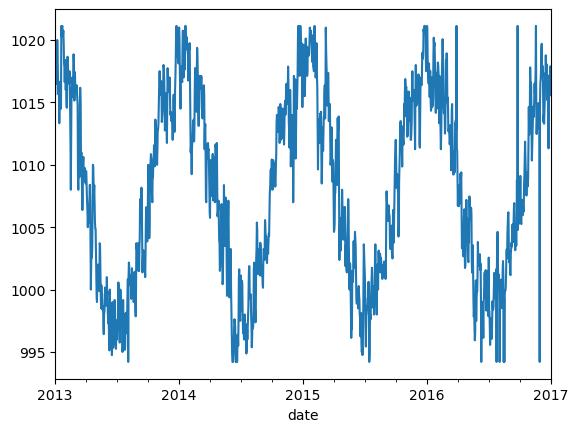

In [27]:
low = data["meanpressure"].quantile(.01)
high = data["meanpressure"].quantile(.99)

data["meanpressure"] = data["meanpressure"].clip(low, high)
data["meanpressure"].plot()

In [28]:
size = len(data)
train, test = data.iloc[:3 * size // 4], data.iloc[3 * size // 4:]

scaler = StandardScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

## Експерименти

In [29]:
def create_dataset(X, window_size=14, target_size=7):
    # Create a sliding window view of the dataset
    t, n = X.shape
    X_slide = np.zeros((t - window_size - target_size + 1, window_size + target_size, n))

    for i in range(X_slide.shape[0]):
        X_slide[i] = X[i: i + window_size + target_size]
    return X_slide[:, : window_size], X_slide[:, window_size:]

In [30]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed


def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # store
        scores.append(mse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = s / (actual.shape[0] * actual.shape[1])
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:,]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

def split_into_windows(test, n_output):
    return np.array(np.split(test[:len(test) // n_output * n_output], n_output)).transpose(1, 0, 2)    

# evaluate a single model
def evaluate_model(train, test, n_input, n_output, build_model, evaluate_forecasts=evaluate_forecasts):
    # fit model
    model = build_model(train, n_input, n_output)
    # history is a list of weekly data
    history = [x for x in split_into_windows(train, n_output)]
    # walk-forward validation over each week
    test = split_into_windows(test, n_output)
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores

### Univariate models

In [31]:
train_univariate, test_univariate = train[:, [0]], test[:, [0]]
days = data.index.day_name()[:7]


#### LSTM

In [32]:
def build_model_lstm(train, n_input, n_output):
    # prepare data
    train_x, train_y = create_dataset(train, n_input, n_output)
    # define parameters
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Epoch 1/20
68/68 [==============================] - 5s 27ms/step - loss: 0.4403
Epoch 2/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1270
Epoch 3/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1119
Epoch 4/20
68/68 [==============================] - 2s 27ms/step - loss: 0.1125
Epoch 5/20
68/68 [==============================] - 2s 28ms/step - loss: 0.1067
Epoch 6/20
68/68 [==============================] - 2s 26ms/step - loss: 0.1031
Epoch 7/20
68/68 [==============================] - 2s 27ms/step - loss: 0.1009
Epoch 8/20
68/68 [==============================] - 2s 27ms/step - loss: 0.1014
Epoch 9/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1023
Epoch 10/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1000
Epoch 11/20
68/68 [==============================] - 3s 39ms/step - loss: 0.0998
Epoch 12/20
68/68 [==============================] - 2s 26ms/step - loss: 0.1007
Epoch 13/20
68/68 [==================

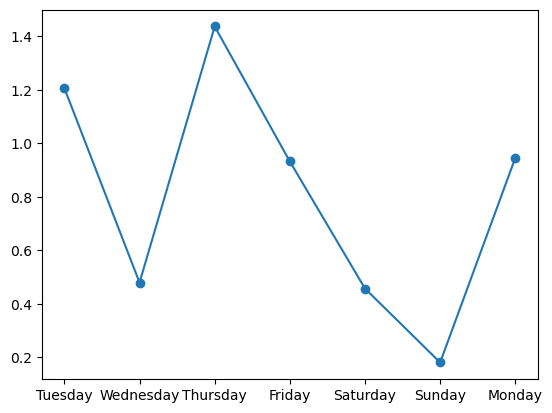

In [33]:
n_input = 14
n_output = 7

score, scores = evaluate_model(train_univariate, test_univariate, n_input, n_output, build_model_lstm)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

Epoch 1/20
67/67 [==============================] - 4s 36ms/step - loss: 0.5790
Epoch 2/20
67/67 [==============================] - 2s 36ms/step - loss: 0.1575
Epoch 3/20
67/67 [==============================] - 2s 35ms/step - loss: 0.1263
Epoch 4/20
67/67 [==============================] - 3s 47ms/step - loss: 0.1124
Epoch 5/20
67/67 [==============================] - 3s 38ms/step - loss: 0.1059
Epoch 6/20
67/67 [==============================] - 2s 36ms/step - loss: 0.1054
Epoch 7/20
67/67 [==============================] - 2s 36ms/step - loss: 0.1012
Epoch 8/20
67/67 [==============================] - 2s 36ms/step - loss: 0.1000
Epoch 9/20
67/67 [==============================] - 3s 38ms/step - loss: 0.1009
Epoch 10/20
67/67 [==============================] - 2s 37ms/step - loss: 0.1007
Epoch 11/20
67/67 [==============================] - 3s 39ms/step - loss: 0.0997
Epoch 12/20
67/67 [==============================] - 2s 36ms/step - loss: 0.1011
Epoch 13/20
67/67 [==================

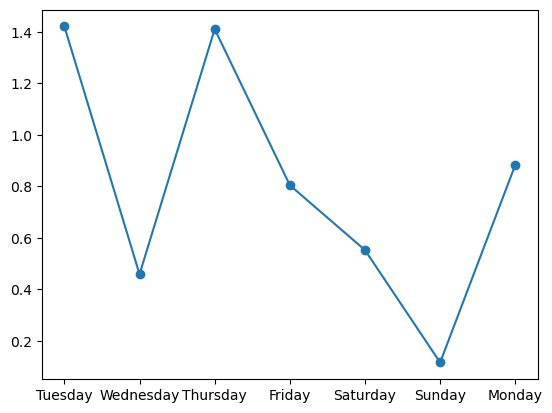

In [34]:
n_input = 21
n_output = 7

score, scores = evaluate_model(train_univariate, test_univariate, n_input, n_output, build_model_lstm)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

Epoch 1/20
68/68 [==============================] - 3s 16ms/step - loss: 0.5350
Epoch 2/20
68/68 [==============================] - 1s 16ms/step - loss: 0.1280
Epoch 3/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1118
Epoch 4/20
68/68 [==============================] - 1s 16ms/step - loss: 0.1075
Epoch 5/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1048
Epoch 6/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1034
Epoch 7/20
68/68 [==============================] - 1s 16ms/step - loss: 0.1040
Epoch 8/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1019
Epoch 9/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1002
Epoch 10/20
68/68 [==============================] - 1s 16ms/step - loss: 0.1026
Epoch 11/20
68/68 [==============================] - 1s 15ms/step - loss: 0.1029
Epoch 12/20
68/68 [==============================] - 1s 18ms/step - loss: 0.0999
Epoch 13/20
68/68 [==================

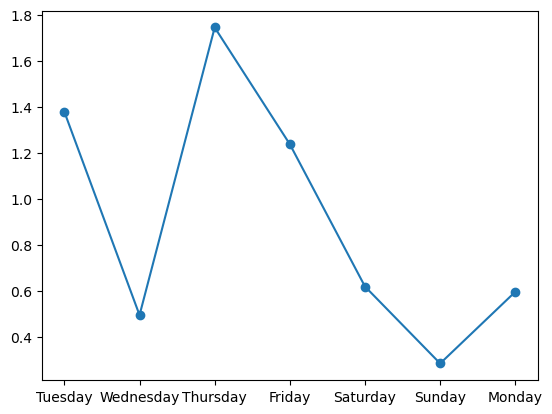

In [35]:
n_input = 7
n_output = 7

score, scores = evaluate_model(train_univariate, test_univariate, n_input, n_output, build_model_lstm)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

#### Encoder-Decoder

In [36]:
def build_model_ecoder_decoder(train, n_input, n_output):
    train_x, train_y = create_dataset(train, n_input, n_output)
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Epoch 1/20
68/68 [==============================] - 7s 53ms/step - loss: 0.4189
Epoch 2/20
68/68 [==============================] - 3s 42ms/step - loss: 0.1423
Epoch 3/20
68/68 [==============================] - 3s 46ms/step - loss: 0.1151
Epoch 4/20
68/68 [==============================] - 3s 42ms/step - loss: 0.1108
Epoch 5/20
68/68 [==============================] - 3s 41ms/step - loss: 0.1047
Epoch 6/20
68/68 [==============================] - 3s 38ms/step - loss: 0.1004
Epoch 7/20
68/68 [==============================] - 3s 41ms/step - loss: 0.1029
Epoch 8/20
68/68 [==============================] - 3s 38ms/step - loss: 0.1030
Epoch 9/20
68/68 [==============================] - 3s 40ms/step - loss: 0.1008
Epoch 10/20
68/68 [==============================] - 3s 38ms/step - loss: 0.1008
Epoch 11/20
68/68 [==============================] - 3s 42ms/step - loss: 0.0995
Epoch 12/20
68/68 [==============================] - 3s 48ms/step - loss: 0.0962
Epoch 13/20
68/68 [==================

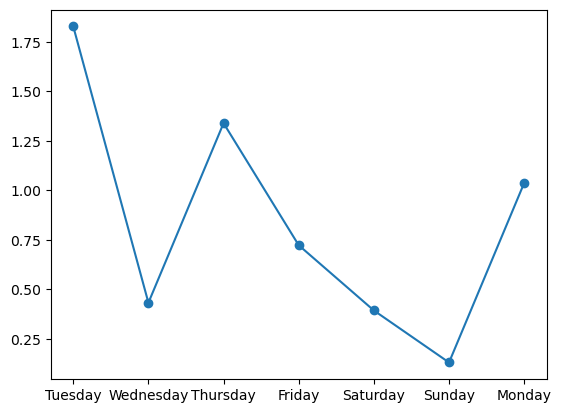

In [37]:
n_input = 14
n_output = 7

score, scores = evaluate_model(train_univariate, test_univariate, n_input, n_output, build_model_ecoder_decoder)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

### Multivariate

In [38]:
def evaluate_forecasts_multivariate(actual, predicted):
    scores_all = list()
    score_all = list()
    for j in range(actual.shape[2]):
        scores = []
        for i in range(actual.shape[1]):
            mse = mean_squared_error(actual[:, i, j], predicted[:, i, j])
            scores.append(mse)
        # calculate overall mse
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s += (actual[row, col, j] - predicted[row, col, j])**2
        score = s / (actual.shape[0] * actual.shape[1])

        score_all.append(score)
        scores_all.append(scores)
    return score_all, scores_all

In [41]:
def build_model_encoder_decoder_multivariate(train, n_input, n_output):
    train_x, train_y = create_dataset(train, n_input, n_output)
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Epoch 1/20
68/68 [==============================] - 7s 38ms/step - loss: 0.6332
Epoch 2/20
68/68 [==============================] - 3s 40ms/step - loss: 0.4224
Epoch 3/20
68/68 [==============================] - 3s 40ms/step - loss: 0.3934
Epoch 4/20
68/68 [==============================] - 3s 41ms/step - loss: 0.3776
Epoch 5/20
68/68 [==============================] - 3s 40ms/step - loss: 0.3660
Epoch 6/20
68/68 [==============================] - 4s 53ms/step - loss: 0.3623
Epoch 7/20
68/68 [==============================] - 3s 41ms/step - loss: 0.3523
Epoch 8/20
68/68 [==============================] - 3s 42ms/step - loss: 0.3434
Epoch 9/20
68/68 [==============================] - 3s 41ms/step - loss: 0.3443
Epoch 10/20
68/68 [==============================] - 3s 39ms/step - loss: 0.3367
Epoch 11/20
68/68 [==============================] - 3s 38ms/step - loss: 0.3333
Epoch 12/20
68/68 [==============================] - 3s 41ms/step - loss: 0.3267
Epoch 13/20
68/68 [==================

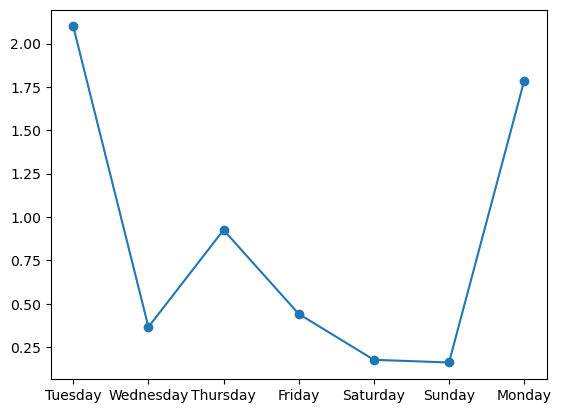

In [42]:
n_input = 14
n_output = 7

score_all, scores_all = evaluate_model(
    train,
    test,
    n_input,
    n_output,
    build_model_encoder_decoder_multivariate,
    evaluate_forecasts_multivariate
)

for col, score, scores in zip(data.columns, score_all, scores_all):
    summarize_scores(col, score, scores)

plt.plot(days, scores_all[0], marker='o', label='lstm')
plt.show()

## Висновки

Показники MSE моделей

- lstm: [0.805] 1.2, 0.5, 1.4, 0.9, 0.5, 0.2, 0.9
- lstm encoder decoder: [0.841] 1.8, 0.4, 1.3, 0.7, 0.4, 0.1, 1.0
- lstm encoder decoder multivariative: [0.851] 2.1, 0.4, 0.9, 0.4, 0.2, 0.2, 1.8


З аналізу показників MSE (Mean Squared Error) можна зробити декілька висновків:

У моделі LSTM (Long Short-Term Memory) середнє значення MSE становить 0.805. Вона показує найкращі результати порівняно з іншими двома моделями.

Модель LSTM Encoder-Decoder має середнє значення MSE 0.841, що трохи гірше, ніж у базової LSTM моделі.

Модель LSTM Encoder-Decoder з багатовимірними вхідними даними має середнє значення MSE 0.851, що є найгіршим результатом серед усіх трьох моделей.

Отже, можна зробити висновок, що модель, яка базується на багатовимірних вхідних даних (LSTM Encoder-Decoder з багатовимірними вхідними даними), не є більш стабільною порівняно з моделлю, що використовує одномірні дані (звичайна LSTM модель). У даному випадку, базова LSTM модель має найкращі результати та більш стабільну точність прогнозів. Ці результати можуть свідчити про те, що модель LSTM Encoder-Decoder з одновимірними та багатовимірними вхідними даними можуть бути більш схильними до перенавчання, ніж LSTM модель, що використовує одномірні дані.